# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
總報酬率,1002.9700
年化報酬率,110893.1100
日報酬率,1.9397
最大回撤,-66.2500
交易次數,11.0000
勝率,45.4500
平均持有K棒數,94.1800
平均每筆報酬率,12.6900


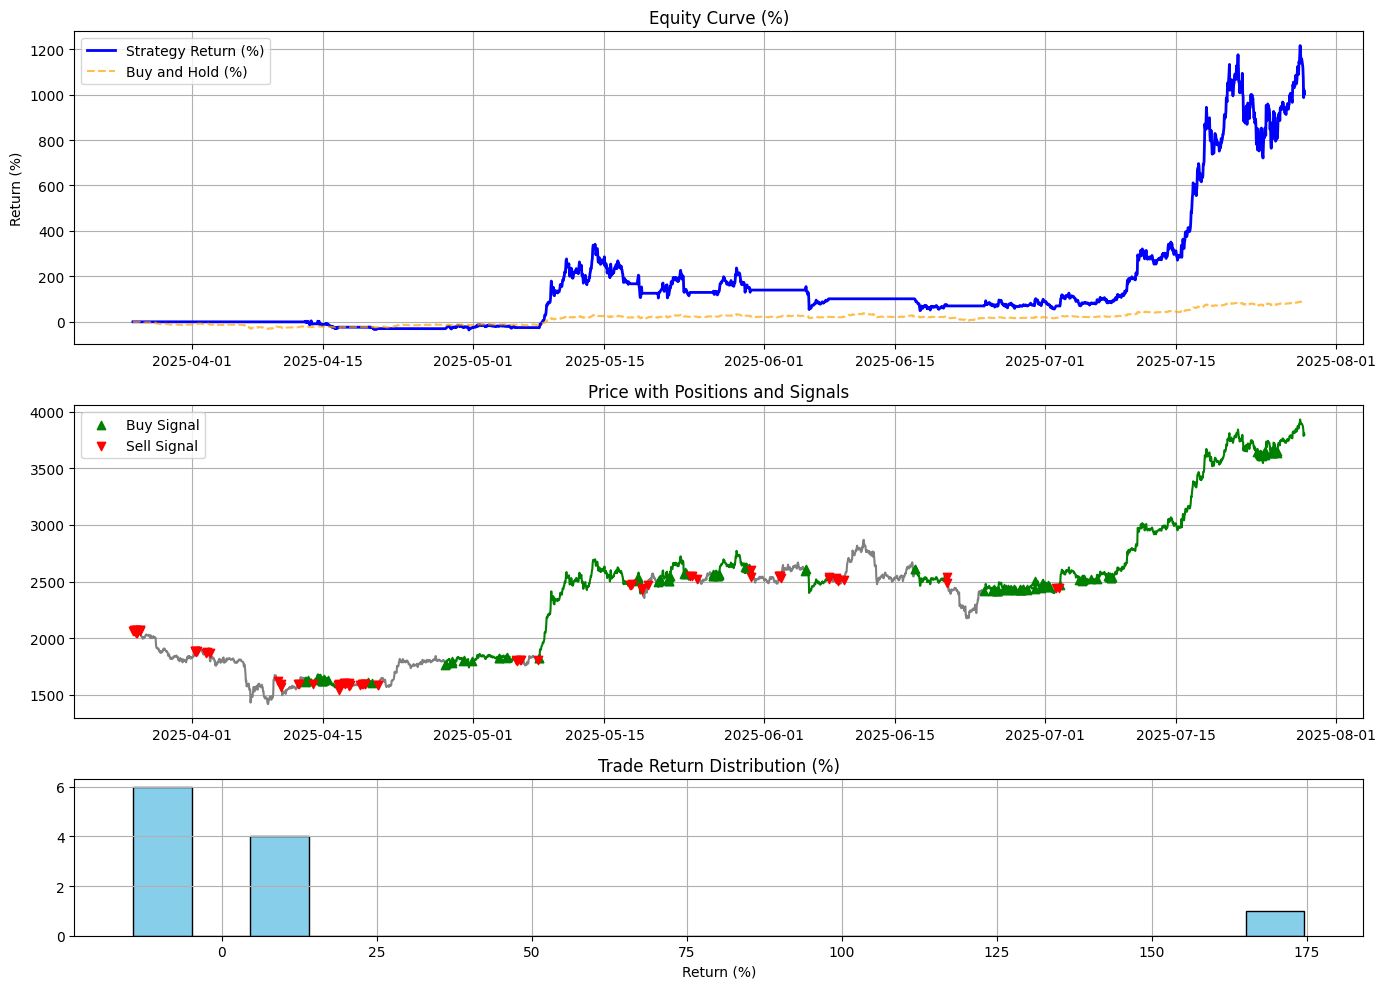

In [5]:
from Technicalindicatorstrategy import superTrend,vegas
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
from datetime import datetime


df_signals = vegas.get_signals('ETHUSDT','1h',datetime.now(),3000)

result = backtest_signals(
    df_signals,
    initial_capital=100, 
    fee_rate = 0.0004,
    leverage=5, 
    allow_short=False)

display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result['fig'])
